# Mangrove Extent Change
Change in extent of mangrove forests from 1996 to 2016. Gained, lost, and maintained (stable) area are displayed separately. Disaggregated by GCRMN region or by country/territory.

_Author: Peter Kerins_  
_Created: 18 May 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Vertical bar chart
- Value is mangrove area of each type (gain, loss, stable)
- Single stacked bar

## Data
GCRMN Region data: [ocn.calcs.009a Mangrove Extent Change by GCRMN Region](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_calcs_009a_mangrove_extent_change_gcrmn)  
~Country/Territory data: [ocn.calcs.009a Mangrove Extent Change by GCRMN Region](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_calcs_009b_mangrove_extent_change_gcrmn)~  

- [Global Mangrove Watch (1996 - 2016)](https://data.unep-wcmc.org/datasets/45) from WCMC ([for.005a.rw2 Mangrove Forests](https://resourcewatch.carto.com/u/wri-rw/dataset/for_005a_mangrove_edit))  

## Preparation

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 400
widget_height = 300

---

# GCRMN Regions

## Global
Global figures include mangroves located outside of GCRMN regions (`gcrmn_reg=='None'`)

### Queries
Main data
```sql
WITH prepped_data AS (
  SELECT 'World' AS gcrmn_reg, SUM(mang_polys) AS mang_polys, SUM(extent1996) AS extent1996, SUM(extent2016) AS extent2016, SUM(gain2016) AS gain2016, SUM(loss2016) AS loss2016, SUM(extent2016)-SUM(gain2016) AS stable2016, SUM(loss2016)*-1 AS range_min, SUM(extent2016) AS range_max
  FROM ocn_calcs_009a_mangrove_extent_change_gcrmn )
  
SELECT 'Gain' AS area_type, gain2016 AS area_value, stable2016 AS y0, extent2016 AS y2, gain2016/extent1996 AS area_fraction
FROM prepped_data
UNION ALL
SELECT 'Stable' AS area_type, stable2016 AS area_value, 0.0 AS y0, stable2016 AS y2, stable2016/extent1996 AS area_fraction
FROM prepped_data
UNION ALL
SELECT 'Loss' AS area_type, loss2016 AS area_value, loss2016*-1 AS y0, 0.0 AS y2, loss2016/extent1996 AS area_fraction
FROM prepped_data
```

Net change data
```sql
SELECT SUM(extent2016)-SUM(extent1996) AS absolute_change, (SUM(extent2016)-SUM(extent1996))/SUM(extent1996) AS fraction_change  
FROM ocn_calcs_009a_mangrove_extent_change_gcrmn
```

### Specification

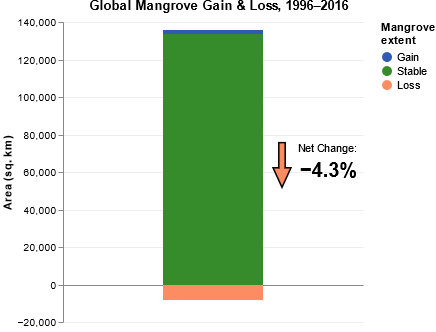

In [4]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Mangrove forest gained, lost, or stable between 1996 and 2006 globally",
  "width": 300,
  "height": 300,
  "padding": {
    "left": 2, 
    "top": 0, 
    "right": 0, 
    "bottom": 5
  },
  "autosize": {
    "type": "pad",
    "resize": true,
    "contains": "padding"
  },
  "signals": [
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=WITH prepped_data AS (SELECT 'World' AS gcrmn_reg, SUM(mang_polys) AS mang_polys, SUM(extent1996) AS extent1996, SUM(extent2016) AS extent2016, SUM(gain2016) AS gain2016, SUM(loss2016) AS loss2016, SUM(extent2016)-SUM(gain2016) AS stable2016, SUM(loss2016)*-1 AS range_min, SUM(extent2016) AS range_max FROM ocn_calcs_009a_mangrove_extent_change_gcrmn ) SELECT 'Gain' AS area_type, gain2016 AS area_value, stable2016 AS y0, extent2016 AS y2, gain2016/extent1996 AS area_fraction FROM prepped_data UNION ALL SELECT 'Stable' AS area_type, stable2016 AS area_value, 0.0 AS y0, stable2016 AS y2, stable2016/extent1996 AS area_fraction FROM prepped_data UNION ALL SELECT 'Loss' AS area_type, loss2016 AS area_value, loss2016*-1 AS y0, 0.0 AS y2, loss2016/extent1996 AS area_fraction FROM prepped_data",
      "format": {
        "type": "json",
        "property": "rows"
      },
      "transform": [
        {
          "type": "formula",
          "expr": "if(datum.area_type=='Unprotected','(Outside of MPA)', if(datum.area_type=='Protected','(Other MPA)', '(No-Take Area)'))",
          "as": "suffix"
        }
      ]
    }
  ],
  "title": {
    "text": 
      {"signal": "'Global Mangrove Gain & Loss, 1996–2016'"}
  },
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {
        "data": "table",
        "field": "gcrmn_reg"
      },
      "range": "width",
      "padding": 0
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {
        "data": "table",
        "fields": [
            "y0",
            "y2"
        ]
      },
      "range": "height",
      "round": true,
      "zero": true,
      "nice": true
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": {
        "data": "table",
        "field": "area_type"
      },
      "range": [
        "#2F5Bb2",
        "#368C2B",
        "#FC8D62"
      ]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Area (sq. km)",
      "labelOverlap": "greedy",
      "labelSeparation": 20,
      "grid": true,
      "encode": {
        "grid": {
          "enter": {
            "stroke": {
              "signal": "(datum.value==0 ? '#888888' : '#eeeeee')"
            }
          }
        }
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {
        "data": "table"
      },
      "encode": {
        "enter": {
          "xc": {
            "signal": "width/2"
          },
          "width": {
            "signal": "2*width/6"
          },
          "y": {
            "scale": "yscale",
            "field": "y0"
          },
          "y2": {
            "scale": "yscale",
            "field": "y2"
          },
          "tooltip": {
            "signal": "{title:datum.area_type,'Area':format(datum.area_value,',d')+' sq. km', 'Relative to 1996 extent':format(datum.area_fraction,'.1%')}"
          }
        },
        "update": {
          "fillOpacity": {
            "value": 1
          },
          "fill": {
            "scale": "color",
            "field": "area_type"
          }
        },
        "hover": {
          "fill": {
            "value": "#aaaaaa"
          }
        }
      }
    },
    {
      "type": "group",
      "name": "net_group",
      "data": [ 
        {
          "name": "net_data",
          "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT SUM(extent2016)-SUM(extent1996) AS absolute_change, (SUM(extent2016)-SUM(extent1996))/SUM(extent1996) AS fraction_change FROM ocn_calcs_009a_mangrove_extent_change_gcrmn",
          "format": {
            "type": "json",
            "property": "rows"
          }
        }
      ],
      "encode": {
        "enter": {
          "x": {"signal": "width*2/3"},
          "yc": {"signal": "height/2"},
          "width": {"value": 100},
          "height": {"value": 100},
          "clip": {"value": false},
          "opacity": {"value": 0},
          "cornerRadius": {"value": 0},
          "strokeWidth": {"value": 1},
          "strokeForeground": {"value": false},
          "fill": {"value": null},
          "stroke": {"value": "black"}
        }
      },
      "marks": [
        {
          "type": "symbol",
          "from": {"data": "net_data"},
          "encode": {
            "enter": {
              "stroke": {"value": "black"},
              "x": {"field": {"group": "width"}, "mult": 0.19},
              "y": {"field": {"group": "height"}, "mult": 0.43},
              "size": {"signal": "2000"},
              "shape": {"value": "arrow"},
              "strokeWidth": {"value": 1.5},
              "fillOpacity": {"value": 1.0},
              "strokeOpacity": {"value": 1.0}
            },
            "update": {
              "fill": {"signal": "(datum.absolute_change < 0 ? '#FC8D62' : '#2F5Bb2')"},
              "angle": {"signal": "(datum.absolute_change < 0 ? 180 : 0)"},
              "opacity": {"value": 1}
            },
            "hover": {
              "opacity": {"value": 0.5}
            }
          }
        },
        {
          "type": "text",
          "name": "net-label",
          "from": {"data": "net_data"},
          "encode": {
            "enter": {
              "fontSize": {"value": 11},
              "fontWeight": {"value": "normal"},
              "fontStyle": {"value": "normal"},
              "baseline": "middle",
              "text": {
                "value": "Net Change:"
              },
              "xc": {"field": {"group": "width"}, "mult": 0.35},
              "yc": {"field": {"group": "height"}, "mult": 0.3}
            }
          }
        },
        {
          "type": "text",
          "name": "net-value",
          "from": {"data": "net_data"},
          "encode": {
            "enter": {
              "fontSize": {"value": 20},
              "fontStyle": {"value": "normal"},
              "fontWeight": {"value": "bold"},
              "baseline": "middle",
              "text": [{"signal": "format(datum.fraction_change,'.1%')"}],
              "x": {"field": {"group": "width"}, "mult": 0.37},
              "yc": {"field": {"group": "height"}, "mult": 0.55},
              "tooltip": {
                "signal": "{'Area':format(datum.absolute_change,',d')+' sq. km'}"
              }
            }
          }
        }
      ]
    }
  ],
  "legends": [
    {
      "fill": "color",
      "direction": "vertical",
      "orient": "right",
      "labelBaseline": "middle",
      "title": [
        "Mangrove",
        "extent"  
      ],
      "encode": {
        "labels": {
          "interactive": true,
          "update": {
            "fill": {
              "value": "#000000"
            },
            "fontSize": {
              "value": "11"
            },
            "dy": {
              "value": 1
            }
          },
          "hover": {
            "fill": {
              "value": "#aaaaaa"
            }
          }
        }
      }
    }
  ]
}
""")
vegaview=dict(spec)
Vega(vegaview)

### RW API
Parent dataset [for.005b.rw0 Mangrove Extent Change](https://resourcewatch.org/data/explore/for005brw0-Mangrove-Extent-Change) ([Admin](https://resourcewatch.org/admin/data/datasets/f31dece0-9256-428a-84de-3a59f5c06bb7/edit))    
[API ID](https://api.resourcewatch.org/v1/dataset/f31dece0-9256-428a-84de-3a59f5c06bb7/) `f31dece0-9256-428a-84de-3a59f5c06bb7`  
[Widgets](https://api.resourcewatch.org/v1/dataset/f31dece0-9256-428a-84de-3a59f5c06bb7/widget?page[size]=100)

Lightly modified version of widget passed to API via [widget script](https://github.com/resource-watch/data-team-tools/blob/master/advanced_widget_writer/advanced_chart_widget_create.py). Key variables to modify in script, besides specification itself:

In [5]:
dataset_id = 'f31dece0-9256-428a-84de-3a59f5c06bb7'
name = 'Global Mangrove Gain & Loss, 1996–2016'
description = 'Mangrove forest gained, lost, or stable between 1996 and 2006 globally'

- [Global](https://api.resourcewatch.org/v1/widget/cbb1b7af-172e-4ee8-8743-af07d53fa48e?env=production)  `cbb1b7af-172e-4ee8-8743-af07d53fa48e`  

## Regional

### Queries
Note that regional filtering happens within widget via transform  

Main data  
```sql
WITH prepped_data AS (
  SELECT gcrmn_reg, mang_polys, extent1996, extent2016, gain2016, loss2016, extent2016-gain2016 AS stable2016, loss2016*-1 AS range_min, extent2016 AS range_max
  FROM ocn_calcs_009a_mangrove_extent_change_gcrmn )
  
SELECT gcrmn_reg, 'Gain' AS area_type, gain2016 AS area_value, stable2016 AS y0, extent2016 AS y2, gain2016/extent1996 AS area_fraction
FROM prepped_data
UNION ALL
SELECT gcrmn_reg, 'Stable' AS area_type, stable2016 AS area_value, 0.0 AS y0, stable2016 AS y2, stable2016/extent1996 AS area_fraction
FROM prepped_data
UNION ALL
SELECT gcrmn_reg, 'Loss' AS area_type, loss2016 AS area_value, loss2016*-1 AS y0, 0.0 AS y2, loss2016/extent1996 AS area_fraction
FROM prepped_data
```

Net change data
```sql
SELECT gcrmn_reg, extent2016-extent1996 AS net_change, (extent2016-extent1996)/extent1996 AS fraction_change
FROM ocn_calcs_009a_mangrove_extent_change_gcrmn
```

### Specification

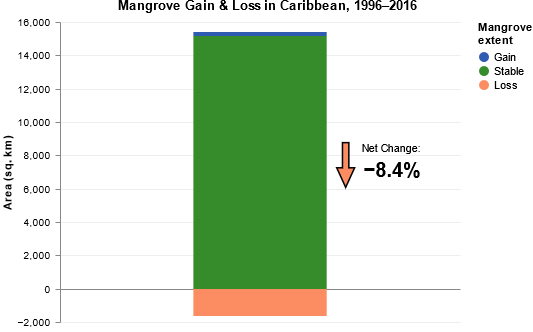

In [6]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Mangrove forest gained, lost, or stable between 1996 and 2006 by GCRMN region",
  "width": 300,
  "height": 300,
  "padding": {
    "left": 2, 
    "top": 0, 
    "right": 0, 
    "bottom": 5
  },
  "autosize": {
    "type": "pad",
    "resize": true,
    "contains": "padding"
  },
  "signals": [
    {
      "name": "region_name",
      "description": "Name of GCRMN region",
      "bind": {
        "input": "select",
        "options": [
          "Australia",
          "Brazil",
          "Caribbean",
          "East Asia",
          "ETP",
          "Pacific",
          "PERSGA",
          "ROPME",
          "South Asia",
          "WIO"
        ],
        "name": "GCRMN Region "
      },
      "value": "Caribbean"
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=WITH prepped_data AS (SELECT gcrmn_reg, mang_polys, extent1996, extent2016, gain2016, loss2016, extent2016-gain2016 AS stable2016, loss2016*-1 AS range_min, extent2016 AS range_max FROM ocn_calcs_009a_mangrove_extent_change_gcrmn ) SELECT gcrmn_reg, 'Gain' AS area_type, gain2016 AS area_value, stable2016 AS y0, extent2016 AS y2, gain2016/extent1996 AS area_fraction FROM prepped_data UNION ALL SELECT gcrmn_reg, 'Stable' AS area_type, stable2016 AS area_value, 0.0 AS y0, stable2016 AS y2, stable2016/extent1996 AS area_fraction FROM prepped_data UNION ALL SELECT gcrmn_reg, 'Loss' AS area_type, loss2016 AS area_value, loss2016*-1 AS y0, 0.0 AS y2, loss2016/extent1996 AS area_fraction FROM prepped_data",
      "format": {
        "type": "json",
        "property": "rows"
      },
      "transform": [
        {
          "type": "filter",
          "expr": "datum.gcrmn_reg == region_name"
        }
      ]
    }
  ],
  "title": {
    "text": 
      {"signal": "'Mangrove Gain & Loss in '+region_name+', 1996–2016'"}
  },
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {
        "data": "table",
        "field": "gcrmn_reg"
      },
      "range": "width",
      "padding": 0
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {
        "data": "table",
        "fields": [
            "y0",
            "y2"
        ]
      },
      "range": "height",
      "round": true,
      "zero": true,
      "nice": true
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": {
        "data": "table",
        "field": "area_type"
      },
      "range": [
        "#2F5Bb2",
        "#368C2B",
        "#FC8D62"
      ]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Area (sq. km)",
      "labelAlign": "right",
      "labelBaseline": "middle",
      "labelPadding": 5,
      "labelOverlap": "greedy",
      "labelSeparation": 20,
      "grid": true,
      "encode": {
        "grid": {
          "enter": {
            "stroke": {
              "signal": "(datum.value==0 ? '#888888' : '#eeeeee')"
            }
          }
        }
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {
        "data": "table"
      },
      "encode": {
        "enter": {
          "xc": {
            "signal": "width/2"
          },
          "width": {
            "signal": "2*width/6"
          },
          "y": {
            "scale": "yscale",
            "field": "y0"
          },
          "y2": {
            "scale": "yscale",
            "field": "y2"
          },
          "tooltip": {
            "signal": "{title:datum.area_type,'Area':format(datum.area_value,',d')+' sq. km', 'Relative to 1996 extent':format(datum.area_fraction,'.1%')}"
          }
        },
        "update": {
          "fillOpacity": {
            "value": 1
          },
          "fill": {
            "scale": "color",
            "field": "area_type"
          }
        },
        "hover": {
          "fill": {
            "value": "#aaaaaa"
          }
        }
      }
    },
    {
      "type": "group",
      "name": "net_group",
      "signal": [
        {
          "name": "region_name",
          "push": "outer"
        }
      ],
      "data": [ 
        {
          "name": "net_data",
          "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gcrmn_reg, extent2016-extent1996 AS absolute_change, (extent2016-extent1996)/extent1996 AS fraction_change FROM ocn_calcs_009a_mangrove_extent_change_gcrmn",
          "format": {
            "type": "json",
            "property": "rows"
          },
          "transform": [
            {
              "type": "filter",
              "expr": "datum.gcrmn_reg == region_name"
            }
          ]
        }
      ],
      "encode": {
        "enter": {
          "x": {"signal": "width*2/3"},
          "yc": {"signal": "height/2"},
          "width": {"value": 100},
          "height": {"value": 100},
          "clip": {"value": false},
          "opacity": {"value": 0},
          "cornerRadius": {"value": 0},
          "strokeWidth": {"value": 1},
          "strokeForeground": {"value": false},
          "fill": {"value": null},
          "stroke": {"value": "black"}
        }
      },
      "marks": [
        {
          "type": "symbol",
          "from": {"data": "net_data"},
          "encode": {
            "enter": {
              "stroke": {"value": "black"},
              "x": {"field": {"group": "width"}, "mult": 0.19},
              "y": {"field": {"group": "height"}, "mult": 0.43},
              "size": {"signal": "2000"},
              "shape": {"value": "arrow"},
              "strokeWidth": {"value": 1.5},
              "fillOpacity": {"value": 1.0},
              "strokeOpacity": {"value": 1.0}
            },
            "update": {
              "fill": {"signal": "(datum.absolute_change < 0 ? '#FC8D62' : '#2F5Bb2')"},
              "angle": {"signal": "(datum.absolute_change < 0 ? 180 : 0)"},
              "opacity": {"value": 1}
            },
            "hover": {
              "opacity": {"value": 0.5}
            }
          }
        },
        {
          "type": "text",
          "name": "net-label",
          "from": {"data": "net_data"},
          "encode": {
            "enter": {
              "fontSize": {"value": 11},
              "fontWeight": {"value": "normal"},
              "fontStyle": {"value": "normal"},
              "baseline": "middle",
              "text": {
                "value": "Net Change:"
              },
              "xc": {"field": {"group": "width"}, "mult": 0.35},
              "yc": {"field": {"group": "height"}, "mult": 0.3}
            }
          }
        },
        {
          "type": "text",
          "name": "net-value",
          "from": {"data": "net_data"},
          "encode": {
            "enter": {
              "fontSize": {"value": 20},
              "fontStyle": {"value": "normal"},
              "fontWeight": {"value": "bold"},
              "baseline": "middle",
              "text": [{"signal": "format(datum.fraction_change,'.1%')"}],
              "x": {"field": {"group": "width"}, "mult": 0.37},
              "yc": {"field": {"group": "height"}, "mult": 0.55},
              "tooltip": {
                "signal": "{'Area':format(datum.absolute_change,',d')+' sq. km'}"
              }
            }
          }
        }
      ]
    }
  ],
  "legends": [
    {
      "fill": "color",
      "direction": "vertical",
      "orient": "right",
      "labelBaseline": "middle",
      "title": [
        "Mangrove",
        "extent"  
      ],
      "encode": {
        "labels": {
          "interactive": true,
          "update": {
            "fill": {
              "value": "#000000"
            },
            "fontSize": {
              "value": "11"
            },
            "dy": {
              "value": 1
            }
          },
          "hover": {
            "fill": {
              "value": "#aaaaaa"
            }
          }
        }
      }
    }
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

### RW API
Parent dataset [for.005b.rw0 Mangrove Extent Change](https://resourcewatch.org/data/explore/for005brw0-Mangrove-Extent-Change) ([Admin](https://resourcewatch.org/admin/data/datasets/f31dece0-9256-428a-84de-3a59f5c06bb7/edit))    
[API ID](https://api.resourcewatch.org/v1/dataset/f31dece0-9256-428a-84de-3a59f5c06bb7/) `f31dece0-9256-428a-84de-3a59f5c06bb7`  
[Widgets](https://api.resourcewatch.org/v1/dataset/f31dece0-9256-428a-84de-3a59f5c06bb7/widget?page[size]=100)

Lightly modified version of widget passed to API via [widget script](https://github.com/resource-watch/data-team-tools/blob/master/advanced_widget_writer/advanced_chart_widget_create.py). Key variables to modify in script, besides specification itself:

In [21]:
dataset_id = 'f31dece0-9256-428a-84de-3a59f5c06bb7'
name = 'Mangrove Gain & Loss in <GCRMN Region>, 1996–2016'
description = 'Global Mangrove Watch mapped the global extent of mangroves as of 1996, 2007, 2008, 2009, 2010, 2015, and 2016. It is the first global map of mangrove extent produced using an automated, reproducible, and globally consistent methodology, using a combination of optical and radar satellite data. This map presents mangrove extent as of 2016, as well as areas of gain and loss since 1996.'

    "info": {
      "caption": "Data: Global Mangrove Watch",
      "widgetLinks": [
        {
          "link": "https://data.unep-wcmc.org/datasets/45",
          "name": "Global Mangrove Extent from Global Mangrove Watch"
        },
        {
          "link": "https://resourcewatch.org/data/explore/386314c4-ab42-47a7-b2cd-596b788e114d",
          "name": "Mangrove Forests on Resource Watch"
        },
        {
          "link": "https://resourcewatch.org/data/explore/f31dece0-9256-428a-84de-3a59f5c06bb7",
          "name": "Mangrove Extent Change on Resource Watch"
        }
      ]
    }

- [Australia](https://api.resourcewatch.org/v1/widget/2121025d-7d99-4785-b047-77db4bf960bc?env=production) `2121025d-7d99-4785-b047-77db4bf960bc`  
- [Brazil](https://api.resourcewatch.org/v1/widget/b3b1c066-c1d1-4e6c-b905-822e30f67f74?env=production) `b3b1c066-c1d1-4e6c-b905-822e30f67f74`  
- [Caribbean](https://api.resourcewatch.org/v1/widget/a39e0314-6715-4cc5-a496-80f1a65e8299?env=production)  `a39e0314-6715-4cc5-a496-80f1a65e8299`  
- [East Asia](https://api.resourcewatch.org/v1/widget/ef1a160a-23a7-40e3-ae82-db4e0484ff15?env=production) `ef1a160a-23a7-40e3-ae82-db4e0484ff15`  
- [ETP](https://api.resourcewatch.org/v1/widget/ece0538e-b546-4255-9f78-a093da404c3a?env=production) `ece0538e-b546-4255-9f78-a093da404c3a`  
- [Pacific](https://api.resourcewatch.org/v1/widget/01332a9f-e9c3-4bb5-8400-bef600fd9608?env=production) `01332a9f-e9c3-4bb5-8400-bef600fd9608`  
- [PERSGA](https://api.resourcewatch.org/v1/widget/35388c78-1464-4531-ba5c-f178408f6ccb?env=production) `35388c78-1464-4531-ba5c-f178408f6ccb`  
- [ROPME](https://api.resourcewatch.org/v1/widget/aa92529d-4c17-4dbf-ad51-28c1993396f0?env=production) `aa92529d-4c17-4dbf-ad51-28c1993396f0`  
- [South Asia](https://api.resourcewatch.org/v1/widget/0a1b8c62-986d-4f0d-bd51-7927230fea2e?env=production) `0a1b8c62-986d-4f0d-bd51-7927230fea2e`  
- [WIO](https://api.resourcewatch.org/v1/widget/f3f8c917-0ca4-4b47-9ab8-3485b98e1b27?env=production) `f3f8c917-0ca4-4b47-9ab8-3485b98e1b27`  

- [Select Region](https://api.resourcewatch.org/v1/widget/4f0afc51-652a-4a26-8c59-529b31067709?env=production) `4f0afc51-652a-4a26-8c59-529b31067709`